# How to create a best listing on Airbnb? A study from Seattle Airbnb listing data

#### In this study, we will look into the listing data from Seatlle to find most interesting facts about it.

We will focus on how to create a good listing, and what aspect impact the most on pricing, user review & popularity of a listing.

The provided data included:
- `listings.csv`: detail of the listing, include detail of rental, place, pricing, user review
- `reviews.csv`: detail of all review of places
- `calendar.csv`: detail of pricing & avaiability of listings by day

On this study, we will focus on `listings.csv` and `calendar.csv` which provided information on pricing & user scores. `reviews.csv` is more focus on review detail which also has a overview on how to create good listing description.

This study included 4 parts:
- Part 1: Review & cleanup data
- Part 2: Pricing overview
- Part 3: How to get good impression by title, description & user reviews
- Part 4: What aspect affect pricing & user review

## Part 1: Review & cleanup data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

In [2]:
# load data
listings_df = pd.read_csv('./data/listings.csv', parse_dates=['first_review', 'last_review', 'host_since'])
calendar_df = pd.read_csv('./data/calendar.csv', parse_dates=['date'])
reviews_df = pd.read_csv('./data/reviews.csv')

### Cleaning calendar_df

In [3]:
calendar_df.head()

listing_id       date available   price
0      241032 2016-01-04         t  $85.00
1      241032 2016-01-05         t  $85.00
2      241032 2016-01-06         f     NaN
3      241032 2016-01-07         f     NaN
4      241032 2016-01-08         f     NaN

In [4]:
# correct price value
cleanup_price = lambda col: col.str.replace(',', '').str.replace('$', '').astype(np.float)
calendar_df['price'] = cleanup_price(calendar_df['price'])

In [5]:
# missing price should be taken from latest price available of current listing, in this case the room is booked 
# forward pricing may not related to fully booked, maybe host did not update the avaiability
calendar_df = calendar_df.groupby('listing_id').apply(lambda group: group.bfill())
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null datetime64[ns]
available     1393570 non-null object
price         1178401 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 42.5+ MB


In [6]:
# drop records with no price available since it is not valueable
# calendar_df = calendar_df.dropna(subset=['price'], axis=0)

In [7]:
# fill available with 0 / 1
calendar_df['available'] = calendar_df['available'].replace({'f': 0, 't': 1}).fillna(1).astype(np.int)

### Cleanup listings_df

In [8]:
listings_df.head()

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  ... review_scores_value  \
0                                                NaN  ...                10.0   
1  Queen Anne is a wonderful, truly functional vi...  ...                10.0   
2  Upper Queen Anne is a charming neighborhood fu...  ...                10.0   
3                                                NaN  ...                 NaN   
4  We are in the beautiful neighborhood of Queen ...  ...                 9.0   

  requires_license license jurisdiction_names instant_bookable  \
0                f     NaN         WASHINGTON                f   
1                f     NaN         WASHINGTON                f   
2                f     NaN         WASHINGTON                f   
3                f     NaN         WASHINGTON                f   
4                f     NaN         WASHINGTON                f   

  cancellation_policy  require_guest_profile_picture  \
0            moderate                              f   
1              strict                              t   
2              strict                              f   
3            flexible                              f   
4              strict                              f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              2   
1                                t                              6   
2                                f                              2   
3                                f                              1   
4                                f                              1   

  reviews_per_month  
0              4.07  
1              1.48  
2              1.15  
3               NaN  
4              0.89  

[5 rows x 92 columns]

In [9]:
# check columns has same values
#print(listings_df['experiences_offered'].value_counts())
#print(listings_df['jurisdiction_names'].value_counts())
print(listings_df['has_availability'].value_counts())

t    3818
Name: has_availability, dtype: int64


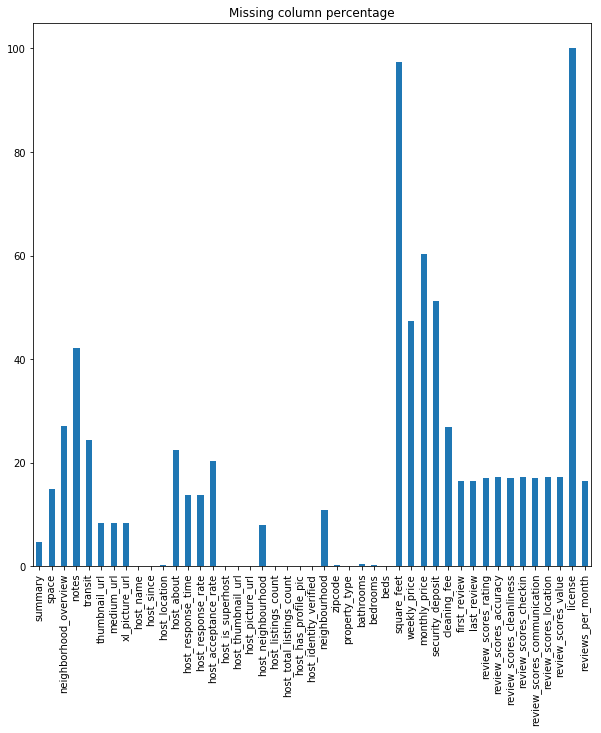

In [10]:
# percentage of missing values for each column
listings_missing_df = listings_df.isnull().mean() * 100
columns_with_nan = listings_missing_df[listings_missing_df > 0]

# plot the results
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Missing column percentage')
columns_with_nan.plot.bar(ax=ax);

In [11]:
# cleanup unrelevant columns or columns with most missing values
listings_df = listings_df.drop(['listing_url', 'scrape_id', 'last_scraped', 'experiences_offered', 'host_url', 
                                'host_thumbnail_url', 'host_picture_url', 'city', 'state', 'zipcode', 'market',
                                'smart_location', 'country_code', 'country', 'calendar_last_scraped', 'jurisdiction_names',
                                'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'square_feet',
                               'license', 'host_total_listings_count', 'has_availability'], axis=1)

In [12]:
# replace t/f values

listings_df[['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'require_guest_profile_picture', 
             'is_location_exact', 'require_guest_phone_verification', 'instant_bookable', 
             'require_guest_profile_picture', 'require_guest_phone_verification']
           ] = listings_df[['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 
                            'require_guest_profile_picture', 'is_location_exact', 
                            'require_guest_phone_verification', 'instant_bookable', 
                            'require_guest_profile_picture', 'require_guest_phone_verification']
           ].replace({'f': 0, 't': 1}).fillna(0).astype(np.int)

In [13]:
# correct price value

listings_df[['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
           ] = listings_df[['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
                          ].apply(cleanup_price)

In [14]:
# cleanup response rate
listings_df['host_response_rate'] = listings_df['host_response_rate'].str.replace('%','').astype(np.float).fillna(0)
listings_df['host_acceptance_rate'] = listings_df['host_acceptance_rate'].str.replace('%','').astype(np.float).fillna(0)


In [15]:
# If nan, security_deposit, cleaning_fee, extra_people fee should be 0
listings_df[['security_deposit', 'cleaning_fee', 'extra_people']
           ] = listings_df[['security_deposit', 'cleaning_fee', 'extra_people']].fillna(0, axis=0)

In [16]:
# get the detail statics of useful quantity columns
static_df = listings_df[['price', 'bathrooms', 'bedrooms', 'beds', 'host_listings_count', 'number_of_reviews',
             'review_scores_rating', 'reviews_per_month', 'minimum_nights', 'maximum_nights', 'guests_included', 'extra_people'
            ]].describe()
static_df.to_clipboard()
static_df

price    bathrooms     bedrooms         beds  \
count  3818.000000  3802.000000  3812.000000  3817.000000   
mean    127.976166     1.259469     1.307712     1.735394   
std      90.250022     0.590369     0.883395     1.139480   
min      20.000000     0.000000     0.000000     1.000000   
25%      75.000000     1.000000     1.000000     1.000000   
50%     100.000000     1.000000     1.000000     1.000000   
75%     150.000000     1.000000     2.000000     2.000000   
max    1000.000000     8.000000     7.000000    15.000000   

       host_listings_count  number_of_reviews  review_scores_rating  \
count          3816.000000        3818.000000           3171.000000   
mean              7.157757          22.223415             94.539262   
std              28.628149          37.730892              6.606083   
min               1.000000           0.000000             20.000000   
25%               1.000000           2.000000             93.000000   
50%               1.000000           9.000000             96.000000   
75%               3.000000          26.000000             99.000000   
max             502.000000         474.000000            100.000000   

       reviews_per_month  minimum_nights  maximum_nights  guests_included  \
count        3191.000000     3818.000000     3818.000000      3818.000000   
mean            2.078919        2.369303      780.447617         1.672603   
std             1.822348       16.305902     1683.589007         1.311040   
min             0.020000        1.000000        1.000000         0.000000   
25%             0.695000        1.000000       60.000000         1.000000   
50%             1.540000        2.000000     1125.000000         1.000000   
75%             3.000000        2.000000     1125.000000         2.000000   
max            12.150000     1000.000000   100000.000000        15.000000   

       extra_people  
count   3818.000000  
mean      10.667627  
std       17.585922  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       20.000000  
max      300.000000

There are 3818 listings with price, from 20 to 1000\\$ per night, with average of 127\\$.

For popularity, a listing got average 2 reviews per month, and maximum of over 12 reviews.

There is more common for a small place, with over 50% listing having 1 bedroom and 1 bed. The average is 1.3 bedrooms and 1.7 beds per listing, and go up to maximum 7 bedrooms and 15 beds.

C:\Users\tienl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\tienl\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


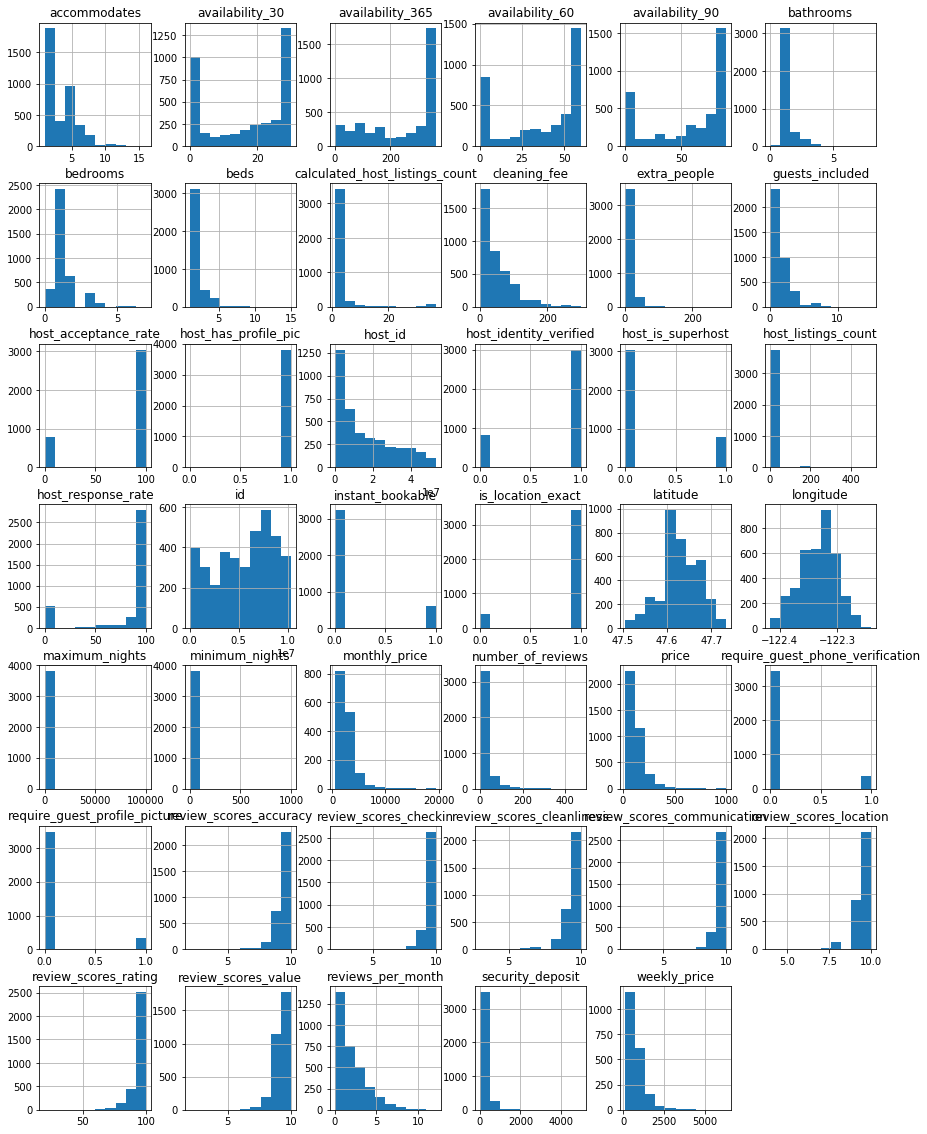

In [17]:
# Get overview of distribution of quantity columns and display with histogram bar chart 
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
listings_df.hist(ax = ax)
fig.savefig('output/distribution.png')
fig.show();

Based on histogrram, we can have some points of interests as bellow:
1. Skewed right distribution on the room size & number of room, price in general, number of review. So in general, there are more small places & more reasonable for smaller groups. For number of review & review per month, it also skewed right, means that the popularity is spread to multiple places
2. Skewed left distribution on the review scores. So places in Seattle seam to have very good user score
3. Central (bell shaped) model for latitude and longitude. That's mean more listings are in central of Seattle than in outside
4. For Avaiability, many places are booked on short term (30, 60, 90 days). And for long term, it is the more availability.

C:\Users\tienl\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


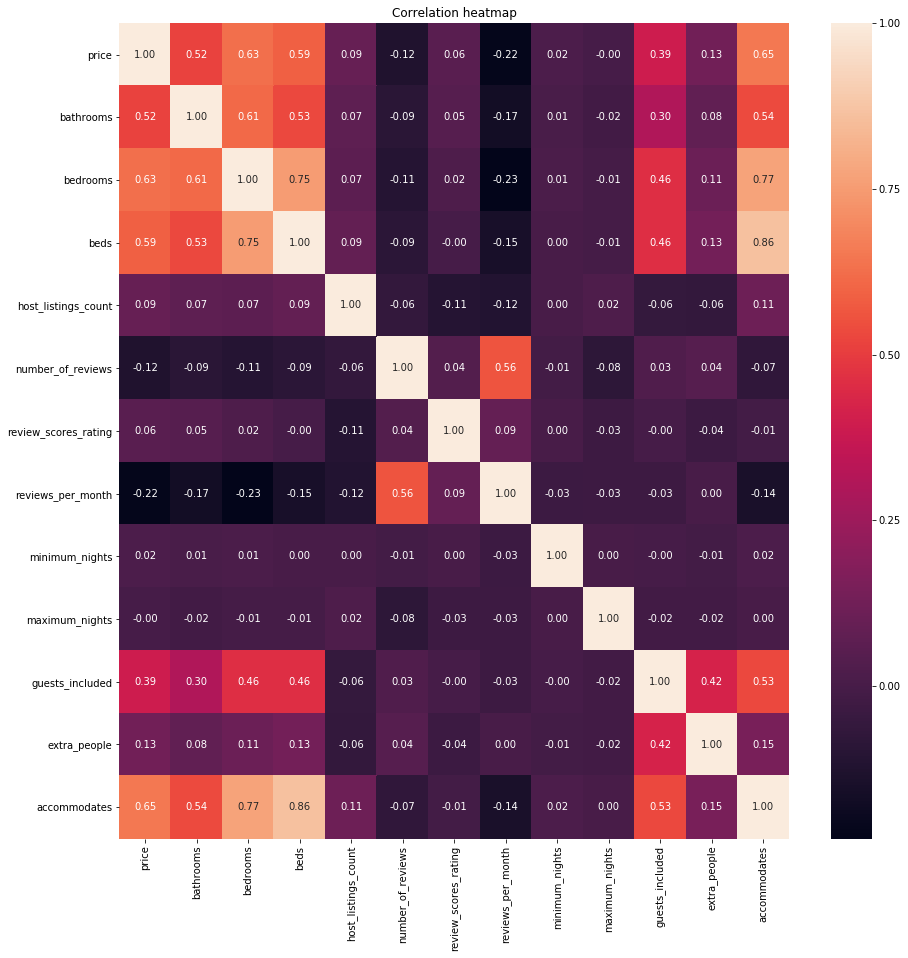

In [18]:
# Get the correlation heatmap of most interesting quantity columns
fig2, ax2 = plt.subplots(figsize=(15,15))
ax2.set_title('Correlation heatmap')
sns.heatmap(listings_df[['price', 'bathrooms', 'bedrooms', 'beds', 'host_listings_count', 'number_of_reviews',
                        'review_scores_rating', 'reviews_per_month', 'minimum_nights', 'maximum_nights', 'guests_included',
                        'extra_people', 'accommodates']
                       ].corr(), annot=True, fmt=".2f", ax=ax2);
fig2.savefig('output/correlation_heatmap.png')
fig2.show();

Based on the correlation matrix heatmap of quantity values, we found some points of interest as bellow:
- Price has strong correlation with number of bathrooms, bedrooms, beds, number of accommodates and number of guests included. Bigger rooms and many more people will have higher price.
- On the other hand, the popularity (based on number of reviews per month) has a slight negative correlation with pricing and other room size as listed above. Seems that smaller room attract more review & popularity more than the bigger one

## Part 2: Price overview

In [19]:
merged_df = listings_df[['id', 'name', 'neighbourhood_group_cleansed']].merge(calendar_df, how='inner', left_on='id', right_on='listing_id')
overview_merge_df = merged_df[['price']].describe().apply(lambda s: s.apply('{0:.5f}'.format))
overview_merge_df.to_clipboard()
overview_merge_df

price
count  1178401.00000
mean       138.26928
std        102.93763
min         10.00000
25%         75.00000
50%        109.00000
75%        165.00000
max       1650.00000

For the whole year, there are more than 1.1M nights available to book. The price vary from 10\\$ to 165\\$, with more than 75\% at about 165\\$. The average price is 138$ per night (higher than the January snapshot of 127\\$).

In [20]:
merged_df['month'] = merged_df['date'].dt.month

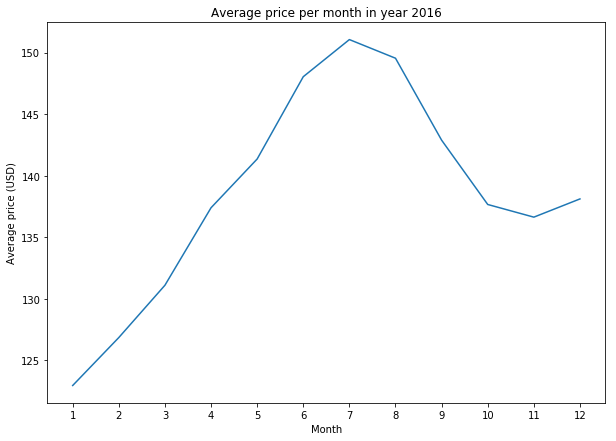

In [21]:
# Average price per month in year 2016
plt.figure(figsize=(10,7))
plt.title('Average price per month in year 2016')
plt.ylabel('Average price (USD)')
plt.xlabel('Month')
plt.xticks(np.arange(1, 13, step=1))
plt.plot(merged_df[merged_df['date'].dt.year==2016].groupby('month')['price'].mean())
plt.savefig('output/average_price.png')
plt.show();

Distributing by month, the cheapest time to book is in the first half of year, begining from 120\\$ average. The most expensive season is from June to April with about 150\\$ per night. Then the price is dropped to under 140\\$ average at the end of year.

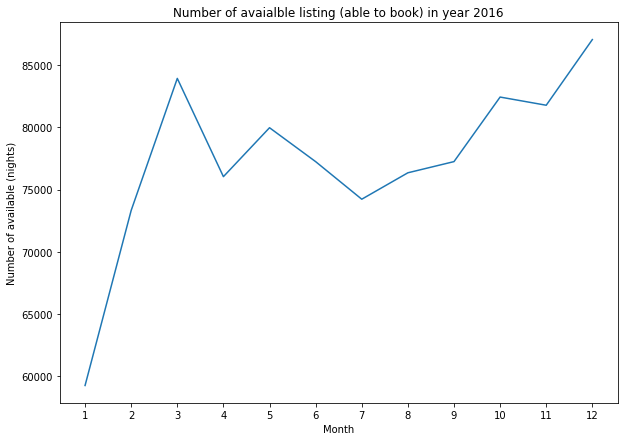

In [22]:
# Number of avaialble listing (able to book) in year 2016
plt.figure(figsize=(10,7))
plt.title('Number of avaialble listing (able to book) in year 2016')
plt.ylabel('Number of available (nights)')
plt.xlabel('Month')
plt.xticks(np.arange(1, 13, step=1))
plt.plot(merged_df[merged_df['date'].dt.year==2016].groupby('month')['available'].sum())
plt.savefig('output/available_listing.png')
plt.show();

The listing is captured durring January. Based on this chart, we can see that people ussualy book up ahead about 3 months, so number of listing available is increasing until March. In the rush season from June to August, people ussualy book upfront comparing to other season. Seems that the most attractive season to visit Seatle is in Summer.

C:\Users\tienl\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


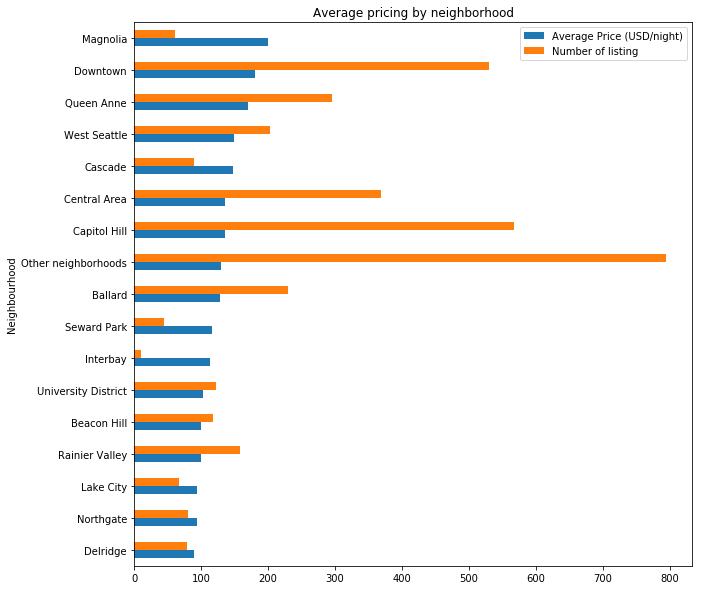

In [23]:
# Average pricing by neigborhood
neighbor_price_df = merged_df[merged_df['date'].dt.year==2016].groupby('neighbourhood_group_cleansed')['price'].mean().sort_values()
neighbor_count_df = listings_df.groupby('neighbourhood_group_cleansed')['id'].count()
join_neighbor_df = pd.concat([neighbor_price_df, neighbor_count_df], axis=1, join='inner')
join_neighbor_df.columns = ['Average Price (USD/night)', 'Number of listing']
join_neighbor_df.index.name = 'Neighbourhood'
# print(join_neighbor_df)
# plot the results
fig, ax = plt.subplots(figsize=(10,10))
# ax.set_xlabel('Price (USD/night) / Number of listing')
ax.set_ylabel('Neighborhood')
ax.set_title('Average pricing by neighborhood')
join_neighbor_df.plot.barh(ax=ax)
fig.savefig('output/average_pricing_by_neighborhood.png')
fig.show();

In [24]:
join_neighbor_df

Average Price (USD/night)  Number of listing
Neighbourhood                                                    
Delridge                             89.500586                 79
Northgate                            93.703373                 80
Lake City                            94.634883                 67
Rainier Valley                       99.796469                159
Beacon Hill                         100.084246                118
University District                 102.624881                122
Interbay                            113.133638                 11
Seward Park                         116.301734                 44
Ballard                             128.837322                230
Other neighborhoods                 129.451080                794
Capitol Hill                        135.285070                567
Central Area                        136.202681                369
Cascade                             147.100312                 89
West Seattle                        149.458374                203
Queen Anne                          169.979899                295
Downtown                            180.448817                530
Magnolia                            200.312912                 61

Most expensive neighbor in Seattle is Magnolia (200\\$), Downtown (180\\$) and Queen Anne (170\\$), where Downtown has most listing available. The neighbor has most number of listing is Capitol Hill, which also has average pricing among others (135\\$)

C:\Users\tienl\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


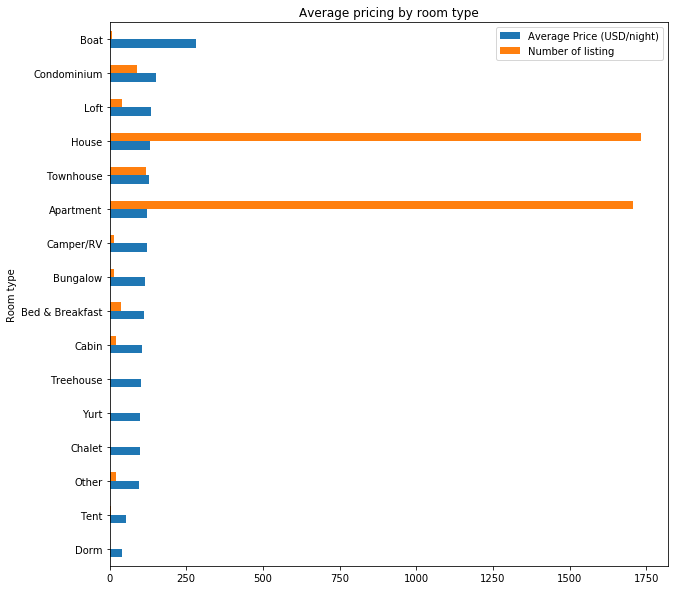

In [25]:
property_type_count_df = listings_df.groupby('property_type')['id'].count()
property_type_price_df = listings_df.groupby('property_type')['price'].mean().sort_values()
property_type_df = pd.concat([property_type_price_df, property_type_count_df], axis=1, join='inner')
property_type_df.columns = ['Average Price (USD/night)', 'Number of listing']
property_type_df.index.name = 'Room type'
# plot the results
fig, ax = plt.subplots(figsize=(10,10))
# ax.set_xlabel('Price (USD/night) / Number of listing')
ax.set_ylabel('Room type')
ax.set_title('Average pricing by room type')
property_type_df.plot.barh(ax=ax)
fig.savefig('output/average_pricing_by_room_type.png')
fig.show();

The room type Boat has most expensive price per night, average from 282$ per night, but also has limited number of listing. Most common room types are House and Apartment

## Part 3: How to get good impression by title, description & user reviews

In [27]:
# Apply word count to description-like columns
word_count = lambda sentence: 0 if pd.isnull(sentence) else str(sentence).split().__len__()
col_word_count = lambda col: col.apply(word_count)
listings_df[['summary_count', 'space_count', 'description_count', 'neighborhood_overview_count', 'notes_count', 
             'transit_count']
           ] = listings_df[['summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit']
                          ].apply(col_word_count, axis=1)

C:\Users\tienl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\tienl\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


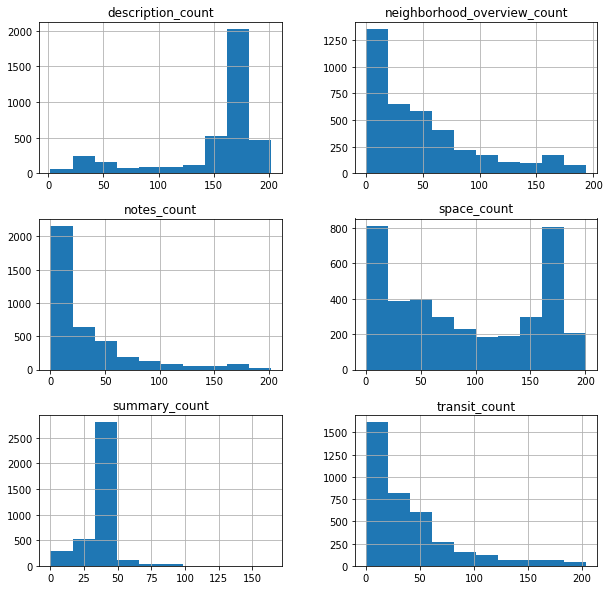

In [28]:
# plot the results
fig, ax = plt.subplots(figsize=(10,10))
listings_df[['summary_count', 'space_count', 'description_count', 'neighborhood_overview_count', 'notes_count', 
             'transit_count']
           ].hist(ax=ax);
fig.savefig('output/word_count_all.png')
fig.show();

In [29]:
top_20_percent_review_per_month = listings_df.iloc[listings_df['reviews_per_month'].sort_values(
    ascending=False)[:int(listings_df['reviews_per_month'].count()*0.2)].index]
top_review_df = pd.concat([top_20_percent_review_per_month, reviews_df], axis=1, join='inner')


C:\Users\tienl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\tienl\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


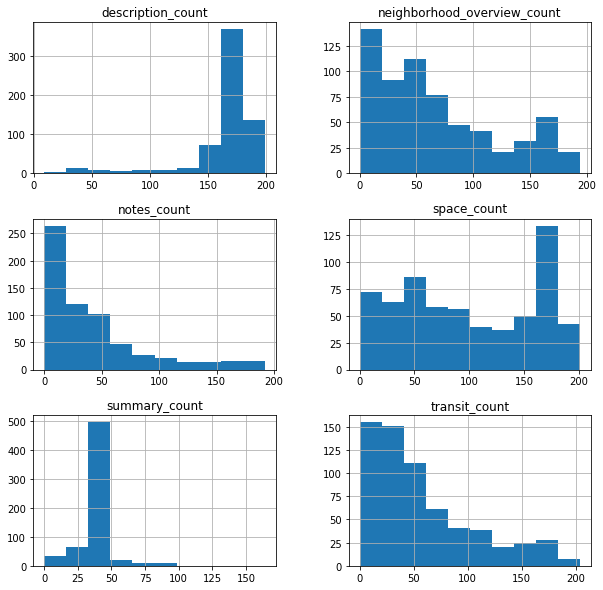

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Top view summary word distribution')
top_20_percent_review_per_month[['summary_count', 'space_count', 'description_count', 'neighborhood_overview_count', 'notes_count', 
             'transit_count']
           ].hist(ax=ax);
fig.savefig('output/word_count_top.png')
fig.show();

Host usually writes about 150 words for description, which provide most useful information for guests. For other types of overview, host provide less information. The second useful information we can see here is the Space. 

There is not much different between the distribution between all listing and top 20% popular listing. But host usually write more detail on other category than description to attract more people.

In [31]:
static_count_df = listings_df[['summary_count', 'space_count', 'description_count', 'neighborhood_overview_count', 'notes_count', 
             'transit_count']].describe()
static_count_df.to_clipboard()
static_count_df

summary_count  space_count  description_count  \
count    3818.000000  3818.000000        3818.000000   
mean       36.971451    90.046883         149.287061   
std        13.532308    66.813323          46.748446   
min         0.000000     0.000000           2.000000   
25%        34.000000    28.000000         154.000000   
50%        39.000000    81.000000         168.000000   
75%        43.000000   162.750000         176.000000   
max       164.000000   201.000000         202.000000   

       neighborhood_overview_count  notes_count  transit_count  
count                  3818.000000  3818.000000    3818.000000  
mean                     48.193033    29.244369      38.654269  
std                      49.313864    41.320625      42.666105  
min                       0.000000     0.000000       0.000000  
25%                       0.000000     0.000000       2.000000  
50%                      36.000000    13.000000      27.000000  
75%                      71.000000    41.000000      55.000000  
max                     194.000000   202.000000     204.000000

In [32]:
def split_set_to_columns(df, column_name, max_dummies_num = 10):
    ''' Split amenities into columns, based on max_dummies_num
    INPUT:
    -df: original dataframe
    -column_name: name of set column, example format:{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,
    Heating,"Family/Kid Friendly",Washer,Dryer}
    -max_dummies_num: maximum number of spliting into columns
    OUTPUT:
    - print out the tupple of most common amenities
    - `column_name` is cut out from original df, then split into `max_dummies_num` categorical column'''
    
    # get dictionary of unique values in lists across dataset rows
    values_dict = {}

    for unique_value in df[column_name].unique(): 
        for value in unique_value.replace('{', '').replace("'", '').replace('"', '').replace('}', '').split(','):
            if value in values_dict:
                values_dict[value] = values_dict[value] + 1
            else:
                values_dict[value] = 0
                
    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)
    print(values_sorted)
    # split into columns
    for value in values_sorted[: max_dummies_num]:
        df[column_name + '_' + value[0]] = df[column_name].str.contains(value[0]).astype(np.int)
        
    return values_sorted

# Split the 
amenities_tupple = split_set_to_columns(listings_df, 'amenities')
listings_df = listings_df.drop('amenities', axis=1)

[('Wireless Internet', 3177), ('Heating', 3139), ('Kitchen', 2947), ('Smoke Detector', 2849), ('Essentials', 2789), ('Dryer', 2554), ('Washer', 2549), ('Internet', 2375), ('Shampoo', 2302), ('TV', 2212), ('Carbon Monoxide Detector', 2114), ('Free Parking on Premises', 1866), ('Fire Extinguisher', 1862), ('Family/Kid Friendly', 1668), ('First Aid Kit', 1467), ('Cable TV', 1234), ('Pets live on this property', 862), ('Indoor Fireplace', 788), ('Hangers', 736), ('Elevator in Building', 685), ('Hair Dryer', 665), ('Laptop Friendly Workspace', 659), ('Iron', 635), ('Safety Card', 627), ('Air Conditioning', 584), ('24-Hour Check-in', 521), ('Dog(s)', 500), ('Buzzer/Wireless Intercom', 467), ('Pets Allowed', 450), ('Cat(s)', 371), ('Gym', 369), ('Wheelchair Accessible', 270), ('Breakfast', 267), ('Hot Tub', 263), ('Suitable for Events', 184), ('Pool', 123), ('Lock on Bedroom Door', 94), ('Smoking Allowed', 78), ('Doorman', 70), ('Other pet(s)', 49), ('Washer / Dryer', 1), ('', 0)]


C:\Users\tienl\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


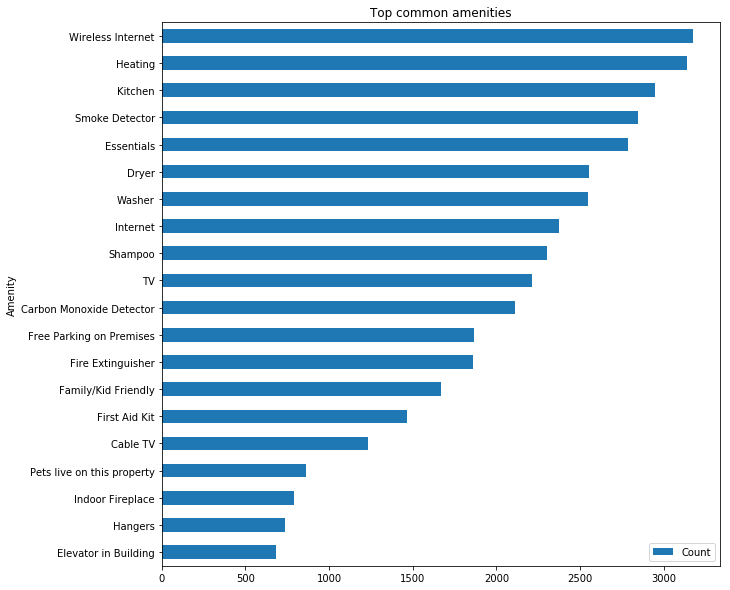

In [33]:
amenities_df = pd.DataFrame(amenities_tupple[:-1], columns =['Amenity', 'Count']).set_index('Amenity')
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Top common amenities')
amenities_df[:20].sort_values(by='Count').plot.barh(ax=ax)
fig.savefig('output/amenities.png')
fig.show();

Most common amenities: Internet, heating, kitchen, smoke detector, essentials, dryer, washer, shampoo, TV

In [34]:
common_words = ['and', 'the', 'a', 'to', 'in', 'of', 'with', 'is', 'from', 'this', 'for', 'on', 'you', 'are', 'has', 'or',
               'we', 'it', 'there', 'it', 'our', 'that', 'an', '2', 'two', '&', 'your', '-', 'have', 'one', 'have', 'will',
               'i', 'was', 'very', 'were', 'as', 'my', 'he', 'she', 'at', 'but', 'so', 'us', 'had', 'would']


In [35]:
# 'summary', 'space', 'description', 'neighborhood_overview', 'transit'
count_all_words = lambda col: col.str.lower().str.replace('.','').str.replace(',','').str.split(expand=True) \
                .stack().value_counts().drop(common_words, axis=0, errors='ignore')

for col_name in ['summary', 'space', 'description', 'neighborhood_overview', 'transit']:
    print(count_all_words(listings_df[col_name]).to_frame(name=col_name)[0:30])



              summary
seattle          1489
downtown         1444
room              934
home              927
bedroom           923
private           909
located           856
restaurants       838
apartment         836
walk              798
bus               761
neighborhood      748
kitchen           702
hill              674
space             596
quiet             588
bed               579
great             578
just              541
lake              521
blocks            516
queen             516
close             511
bathroom          511
full              502
capitol           501
all               487
access            481
house             473
minutes           460
              space
room           2637
bed            1999
seattle        1837
kitchen        1767
bedroom        1726
space          1700
home           1447
house          1377
living         1372
queen          1292
full           1261
apartment      1245
bathroom       1244
private        1118
downtown       109

In [36]:
for col_name in ['summary', 'space', 'description', 'neighborhood_overview', 'transit']:
    print(count_all_words(top_20_percent_review_per_month[col_name]).to_frame(name=col_name)[0:30])

              summary
seattle           247
downtown          239
private           201
apartment         176
bedroom           173
walk              164
located           150
restaurants       148
room              141
neighborhood      139
bus               137
home              136
bed               125
place             114
hill              114
quiet             110
full              110
space             107
kitchen           107
bathroom          104
queen             104
away              101
blocks            100
parking            99
great              89
minutes            88
city               87
heart              87
just               86
close              84
             space
room           452
bed            390
space          386
apartment      296
bathroom       293
seattle        286
private        281
kitchen        281
bedroom        279
full           267
queen          240
be             217
house          215
home           211
living         201
if            

In [37]:
print(count_all_words(reviews_df['comments']).to_frame(name=col_name)[0:30])

              transit
great           58230
stay            49136
place           43410
seattle         36037
clean           28717
location        27030
apartment       25074
comfortable     24409
nice            22612
house           21973
all             20642
room            20272
everything      19216
home            18890
host            18137
easy            17726
neighborhood    17677
time            17033
her             17012
again           16276
really          16239
recommend       15635
if              15478
downtown        15359
definitely      15288
be              15136
perfect         15040
not             14545
also            14239
well            14179


In [38]:
print(count_all_words(top_review_df['comments']).to_frame(name=col_name)[0:30])

              transit
great             441
stay              384
place             317
seattle           265
clean             222
location          217
house             181
comfortable       177
nice              174
room              169
all               161
apartment         153
everything        151
time              137
home              133
easy              130
again             129
perfect           123
definitely        121
really            120
downtown          117
if                115
recommend         114
just              114
neighborhood      113
me                113
be                109
not               108
host              105
space             104


There is also not much different between all listing and most popular listing. Host usualy describe their listing as "private", near to "downtown", able to "walk". On most popular listings, number of "appartment" is higher than "house", opposite to all listings.

For the user comment, people usualy describe their experience as "great", "nice", "comfortable", "clean". 

# Part 4: What aspect affect pricing & user review
Using machine learning model on both quantity and category columns, to see the most correlation aspect that impact the price, review & popularity

In [39]:
#Dropping where the salary has missing values
# drop fields based on relevant info & run the model multiple times to check
drop_fields = ['id', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 
               'host_id', 'host_name', 
               'host_verifications', 'host_about', 'host_location', 'host_neighbourhood', 'street', 
               'neighbourhood', 'neighbourhood_cleansed',
               'weekly_price', 'monthly_price', 'name',
               'calendar_updated', 'is_location_exact', 'availability_30',
               'availability_60', 'availability_90', 'availability_365',
               'latitude', 'longitude'
              ]
df = listings_df.drop(drop_fields, axis=1)

# cleanup datetime
# df['host_since_year'] = df['host_since'].dt.year
# df['host_since_year'] = df['host_since_year'].fillna(df['host_since_year'].mean())
# missing datetime should fill with last item instead of mean (maybe newly created)
convert_to_int_and_fillna = lambda col: col.values.astype('float')
df[['first_review', 'last_review', 'host_since']] = df[['first_review', 'last_review', 'host_since']].apply(convert_to_int_and_fillna, axis=0)
df[['first_review', 'last_review', 'host_since']].fillna(df[['first_review', 'last_review', 'host_since']].max())

df = df.drop(columns = ['host_since'])

#fill in missing values for bathrooms, bedrooms and beds with mode
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
df['beds'] = df['beds'].fillna(df['beds'].mode()[0])

#Drop columns with all NaN values
df = df.dropna(how='all', axis=1)
#Pull a list of the column names of the categorical variables
cat_df = df.select_dtypes(include=['object'])
cat_cols = cat_df.columns
#dummy all the cat_cols
for col in  cat_cols:
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', 
                                                         drop_first=True, dummy_na=False)], axis=1)




In [40]:
df.head()

host_response_rate  host_acceptance_rate  host_is_superhost  \
0                96.0                 100.0                  0   
1                98.0                 100.0                  1   
2                67.0                 100.0                  0   
3                 0.0                   0.0                  0   
4               100.0                   0.0                  0   

   host_listings_count  host_has_profile_pic  host_identity_verified  \
0                  3.0                     1                       1   
1                  6.0                     1                       1   
2                  2.0                     1                       1   
3                  1.0                     1                       1   
4                  2.0                     1                       1   

   accommodates  bathrooms  bedrooms  beds  ...  property_type_Treehouse  \
0             4        1.0       1.0   1.0  ...                        0   
1             4        1.0       1.0   1.0  ...                        0   
2            11        4.5       5.0   7.0  ...                        0   
3             3        1.0       0.0   2.0  ...                        0   
4             6        2.0       3.0   3.0  ...                        0   

   property_type_Yurt  room_type_Private room  room_type_Shared room  \
0                   0                       0                      0   
1                   0                       0                      0   
2                   0                       0                      0   
3                   0                       0                      0   
4                   0                       0                      0   

   bed_type_Couch  bed_type_Futon  bed_type_Pull-out Sofa  bed_type_Real Bed  \
0               0               0                       0                  1   
1               0               0                       0                  1   
2               0               0                       0                  1   
3               0               0                       0                  1   
4               0               0                       0                  1   

   cancellation_policy_moderate  cancellation_policy_strict  
0                             1                           0  
1                             0                           1  
2                             0                           1  
3                             0                           0  
4                             0                           1  

[5 rows x 90 columns]

In [41]:
def get_predict(source_df, response_col, test_size=.30, random_state=42):
    '''Get the prediction values from source_df
    INPUT:
    source_df (pandas Dataframe object): source dataframe
    response_col: name of response column
    test_sise (optional): for changing test split size
    random_sate (optional): for changing random state of spliting
    
    OUTPUT:
    test_score, train_score: LinearRegression test of train & test data
    lm_model: LinearRegression model
    X_train, X_test, y_train, y_test: split sets
    '''
    df = source_df.dropna(subset=[response_col], axis=0)
    # Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df = df.apply(fill_mean, axis=0)

    #Split into explanatory and response variables (X, y)
    X = df.drop(response_col, axis=1)
    y = df[response_col]
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # Instantiate
    lm_model = LinearRegression(normalize=True)
    # Fit
    lm_model.fit(X_train, y_train) 
    # Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)
    # Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [42]:
# predict the price. total_price should included cleaning_fee
# df['total_price'] = df['price'] + df['cleaning_fee']
# df_pred = df.drop(['price', 'cleaning_fee'], axis=1)
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = get_predict(df, 'price')
print(test_score, train_score)

0.6152478555436247 0.6136679882038294


In [43]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = coefficients
    coefs_df['abs_coefs'] = np.abs(coefficients)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df


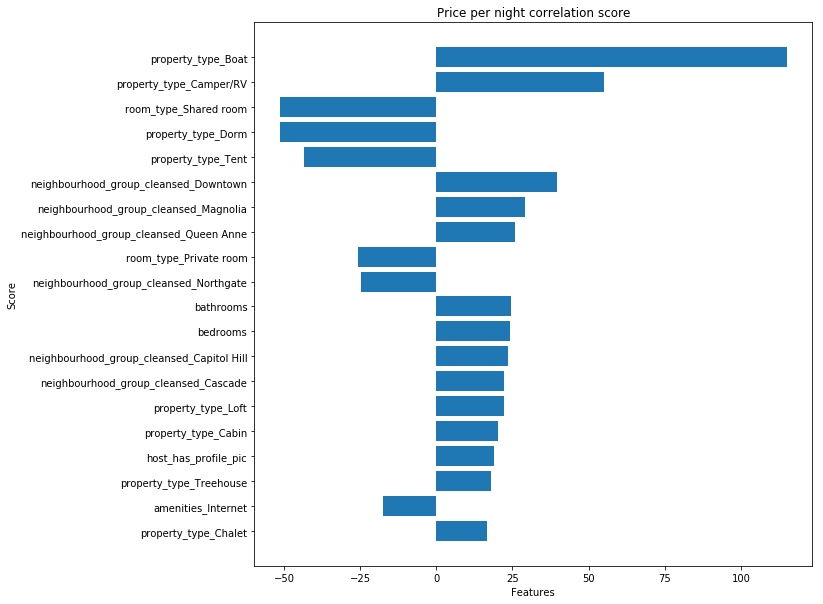

In [44]:
#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
scores = coef_df[:20].sort_values(by='abs_coefs')
y_pos = np.arange(len(scores['est_int']))

plt.figure(figsize=(10,10))
plt.barh(y_pos, scores['coefs'])
plt.yticks(y_pos, scores['est_int'])
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Price per night correlation score')
plt.savefig('output/price_correlation_score.png')
plt.show();

Simmilar to above analyst, room type "Boat", "Camper/RV" has most expensive listing, and affect most on listing. On the opposite, room type "Shared room", "Dorm", "Tent" has more cheaper pricing.

For neighborhood, Downtown, Magnolia usually has higher price. On the other hand, Northgate has more cheaper rooms.

For non-categorical values, number of bathrooms and bedrooms affect the most on pricing.

In [45]:
test_score2, train_score2, lm_model2, X_train2, X_test2, y_train2, y_test2 = get_predict(df, 'reviews_per_month')


In [46]:
print(test_score2, train_score2)

0.6224973218809133 0.6363703818834736


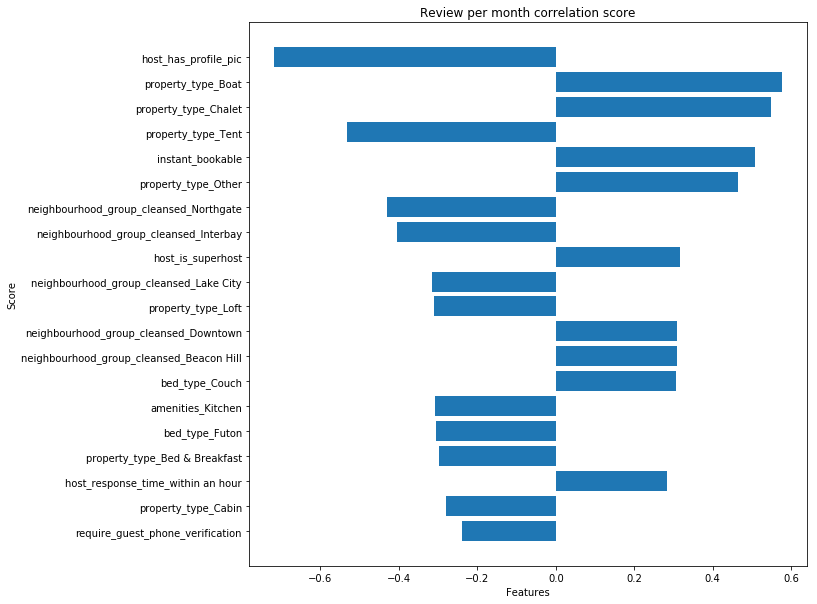

In [47]:
#Use the function
coef_df2 = coef_weights(lm_model2.coef_, X_train2)

#A quick look at the top results
scores = coef_df2[:20].sort_values(by='abs_coefs')
y_pos = np.arange(len(scores['est_int']))

plt.figure(figsize=(10,10))
plt.barh(y_pos, scores['coefs'])
plt.yticks(y_pos, scores['est_int'])
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Review per month correlation score')
plt.savefig('output/popularity_correlation_score.png')
plt.show()

For values that affect the popularity, the feature score is smaller in comparision to the listing price. However we still can see some value that affect the popularity:
- If the host has no profile picture, seems that the listing is not completed and not attrace people to visit
- Despite the high price, the property type "Boat" still attract more people to review. Room type "Chalet" also attract more people. On the other hand, room type "Tent", despite has cheaper pricing, but not attract more people to visit and leave a comment.
- For neigborhood, the more common listing Downtown, Beacon Hill attract more people, opposite with less popuplar place like Nortgate (has least listing also) and Interbay (two of the places has most cheapest rooms).
- Other positive affect popularity is instant bookable, host is super host, and host quick response. The host require guest phone verification however negatively affect the popularity.